In [191]:
import numpy as np
import pandas as pd
from scipy.stats import probplot, ks_2samp,shapiro,kstest
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier 
import lightgbm,xgboost
from xgboost import XGBClassifier
%matplotlib inline
%config inlinebackend.figure_format = 'svg'

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [201]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
X_train=train.drop('target',axis=1)
y_train=train['target']
X_test=test.copy()

In [5]:
train.head()
# ID_code дублирует индекс, возможно, его есть смысл удалить

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [202]:
X_train.ID_code=X_train.index
X_test.ID_code=X_test.index

In [8]:
train.shape

(200000, 202)

In [9]:
train.dropna().shape # пропусков нет

(200000, 202)

In [12]:
train.info()
# все признаки, кроме ID_code, являются числовыми

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [13]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [14]:
train.target.value_counts()
# имеем дисбаланс классов, первого класса около 10%

0    179902
1     20098
Name: target, dtype: int64

In [103]:
# Оценим возможные выбросы.Рассмотрим признаки, у которых значения выходят за диапозоны 3,4,5 сигм.
def anom(X,n):   
    desc=X.describe()
    max_=np.abs(desc.loc['max']-desc.loc['mean'])>=desc.loc['std']*n
    min_=np.abs(desc.loc['min']-desc.loc['mean'])>=desc.loc['std']*n
    anom_max_=list(max_.iloc[np.where(max_==True)].index)
    anom_min_=list(min_.iloc[np.where(min_==True)].index)
    anom_max_.extend(anom_min_)
    anom_pot=list(set(anom_max_))
    return anom_pot

print(f'количество признаков вне {3} сигм {len(anom(X_train,3))}')
print(f'количество признаков вне {4} сигм {len(anom(X_train,4))}')
print(f'количество признаков вне {5} сигм {len(anom(X_train,5))}')

количество признаков вне 3 сигм 196
количество признаков вне 4 сигм 18
количество признаков вне 5 сигм 0


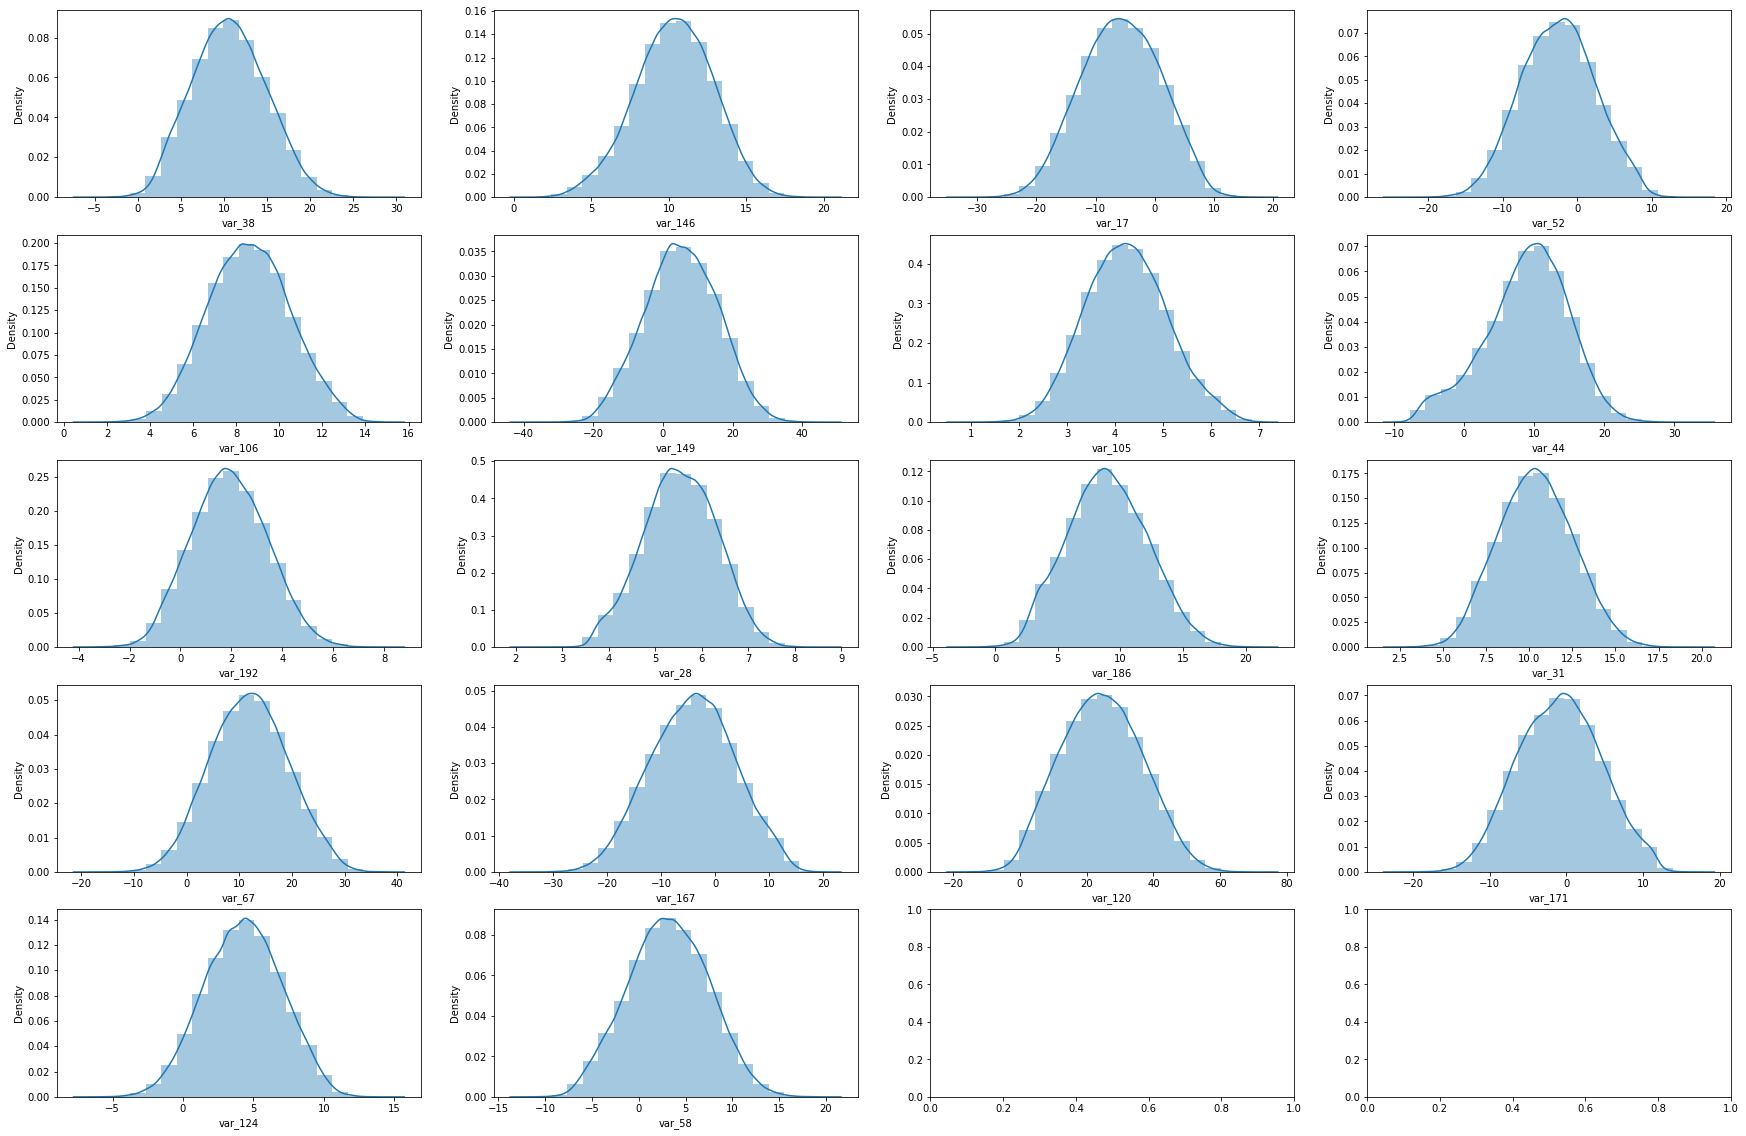

In [151]:
# Построим графики распределения для признаков, выходящих за 4 сигмы

anom_4=anom(X_train,4)

fig, axes = plt.subplots(5, 4, figsize=(30, 20))

for num, feature in enumerate(anom_4):
    data = X_train[feature]
    sns.distplot(X_train[feature],ax=axes[num//4, num%4], bins=20)

    
    y = np.linspace(0, 0.1, 100)
    axes[num//4, num%4].plot([x_mean] * 100, y, label='mean', linestyle=':', linewidth=8)
    axes[num//4, num%4].plot([x_median] * 100, y, label='median', linestyle='--', linewidth=4)
    axes[num//4, num%4].plot([x_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

# есть небольшие хвосты, критичных выбросов не наблюдается

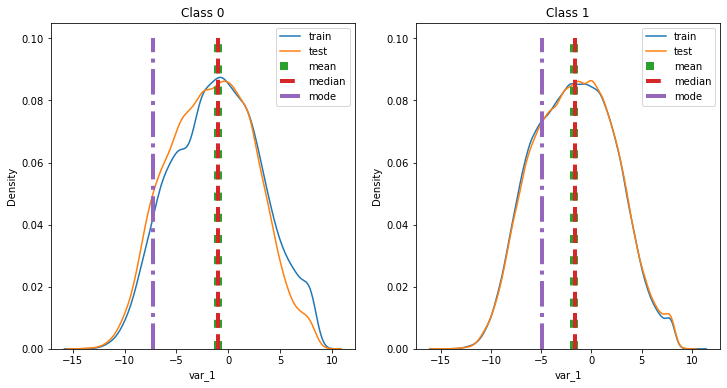

In [179]:
# Посмотрим распределение признака в разрезе классов
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax0,ax1=axes.flatten()

sns.kdeplot(train[train.target==1].var_1,ax=axes[0],label='train' )
sns.kdeplot(train[train.target==0].var_1,ax=axes[1],label='train')
sns.kdeplot(test[train.target==1].var_1,ax=axes[0], label='test')
sns.kdeplot(test[train.target==0].var_1,ax=axes[1],label='test')

x_mean = round(train[train.target==1]['var_1'].mean(), 2)
x_median = train[train.target==1]['var_1'].median()
x_mode = train[train.target==1]['var_1'].mode()[0]

y = np.linspace(0, 0.1, 100)
axes[0].plot([x_mean] * 100, y, label='mean', linestyle=':', linewidth=8)
axes[0].plot([x_median] * 100, y, label='median', linestyle='--', linewidth=4)
axes[0].plot([x_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

x_mean = round(train[train.target==0]['var_1'].mean(), 2)
x_median = train[train.target==0]['var_1'].median()
x_mode = train[train.target==0]['var_1'].mode()[0]

y = np.linspace(0, 0.1, 100)
axes[1].plot([x_mean] * 100, y, label='mean', linestyle=':', linewidth=8)
axes[1].plot([x_median] * 100, y, label='median', linestyle='--', linewidth=4)
axes[1].plot([x_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

axes[0].set_title('Class 0')
axes[1].set_title('Class 1')
axes[0].legend()
axes[1].legend()
# plt.show()
# Очевидно, что большой разницы в распределении признаков нет. И в том, и в том и другом случае 
# распределение похоже на нормальное. Разница между трейном и тестом также несущественна.
# Наблюдается смещение влеао моды относительно медианы и среднего.

Text(0.5, 1.0, 'Class 1')

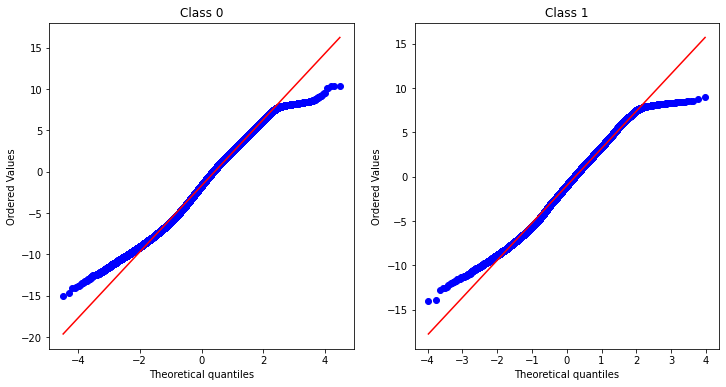

In [183]:
# Построим QQ график

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

probplot(train[train.target==1]['var_1'], plot=axes[1])
probplot(train[train.target==0]['var_1'], plot=axes[0])

axes[0].set_title('Class 0')
axes[1].set_title('Class 1')

# Середина почти идеальна совпадает, крайние значения сглажены по модулю. Такая ситуация характерна практически для всех признаках.

In [185]:
# Рассмотрим корреляцию признаков

train.corr().target.sort_values(ascending=False)

# Линейная корреляция признаков с целевой переменной достаточно слабая,
# и по модулю не превышает 8%.

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

In [188]:
X_train.corr().replace(1,0).max().max()

# Корреляция признаков между собой слабая

0.009713658349534146

In [195]:
# Рассмотрим нелинейную связь

xg = XGBClassifier(max_depth=4)
xg.fit(X_train,y_train)
lg = LGBMClassifier(max_depth=4)
lg.fit(X_train,y_train)

[12:44:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


LGBMClassifier(max_depth=4)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

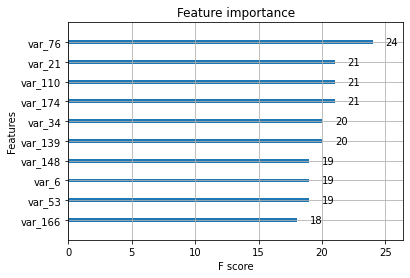

In [196]:
xgboost.plot_importance(xg,max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

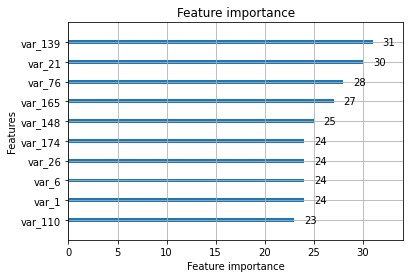

In [197]:
lightgbm.plot_importance(lg,max_num_features=10)

In [199]:
# Есть отличия в Feature importance, выдаваемых lightgbm и xgboost

In [203]:
# Оценим распределения выборок на трейне и на тесте

X_adv=pd.concat([X_train,X_test])
X_adv = X_adv.reset_index(drop=True)

In [204]:
y_adv = np.hstack(
    (np.ones(X_train.shape[0]), np.zeros(X_test.shape[0])))

In [205]:
model = XGBClassifier(max_depth=4)
cross_val_score(model,X_adv,y_adv, scoring='roc_auc').mean()

[13:10:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:13:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.51550373775

In [206]:
#  выборки берутся из одного распеделения 